<a href="https://colab.research.google.com/github/pdoren/Machine-Learning-G105/blob/main/Desaf%C3%ADo_4_Clasificaci%C3%B3n_de_calidad_de_ramen.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Desafío 4 - Clasificación de calidad de ramen

**Nombre**: Pablo Saavedra <br />
**Curso**: Machine Learning (G105)


---

### Importación de librerías

In [92]:
from __future__ import annotations

# --- Standard library ---
from typing import Any, Dict, Iterable, Optional

# --- Third-party ---
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.base import BaseEstimator, ClassifierMixin, clone
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC, SVC
from sklearn.metrics import (
    accuracy_score,
    balanced_accuracy_score,
    classification_report,
    confusion_matrix,
    precision_recall_fscore_support,
    matthews_corrcoef,
    roc_auc_score,
    average_precision_score,
    ConfusionMatrixDisplay,
    RocCurveDisplay,
    PrecisionRecallDisplay,
)
from sklearn.model_selection import (
    GridSearchCV,
    StratifiedKFold,
    cross_val_predict,
    cross_val_score,
    train_test_split,
)
from sklearn.naive_bayes import CategoricalNB, GaussianNB
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, LabelEncoder
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.utils.multiclass import type_of_target

from imblearn.over_sampling import SMOTE

import seaborn as sns
import warnings

# --- Pandas display options ---
pd.options.display.float_format = "{:,.2f}".format


### Funciones útiles

In [ ]:
def plot_hist(_df: pd.DataFrame, _num_cols: list, _n_cols: int = 3, _bins='auto'):
  total = len(_num_cols)
  n_rows = int(np.ceil(total / _n_cols))

  fig, axes = plt.subplots(n_rows, _n_cols, figsize=(5*_n_cols, 4*n_rows))
  axes = axes.flatten()  # Para iterar fácil

  for i, col in enumerate(_num_cols):
      sns.histplot(data=_df[col], kde=False, stat='density', ax=axes[i], bins=_bins)
      sns.kdeplot(data=_df[col], color='tomato', lw=3, ax=axes[i])
      axes[i].set_title(f"Distribución de {col}")

  # Eliminar ejes vacíos si sobran
  for j in range(i+1, len(axes)):
      fig.delaxes(axes[j])

  plt.tight_layout()
  plt.show()

def plot_outliers(_df: pd.DataFrame, _num_cols: list, _n_cols: int = 3):
  total = len(_num_cols)
  n_rows = int(np.ceil(total / _n_cols))

  fig, axes = plt.subplots(n_rows, _n_cols, figsize=(5*_n_cols, 4*n_rows))

  if isinstance(axes, np.ndarray):
      axes = axes.ravel()
  else:
      axes = np.array([axes])

  for i, col in enumerate(_num_cols):
      sns.boxplot(x=_df[col], flierprops = {'markerfacecolor':'tomato', 'marker':'D'}, ax=axes[i])
      axes[i].set_title(f"Outliers en {col}")
      axes[i].set_xlabel(col)

  # Eliminar ejes vacíos si sobran
  for j in range(i+1, len(axes)):
      fig.delaxes(axes[j])

  plt.tight_layout()
  plt.show()


def clean_outliers(_df: pd.DataFrame, _cols: list, _k: float=1.5):
  df_ret = _df.copy()
  for col in _cols:
    while True:
      q1, q3 = df_ret[col].quantile([.25, .75])
      iqr = q3 - q1
      low, high = q1 - _k * iqr, q3 + _k * iqr
      mask_out = (df_ret[col] < low) | (df_ret[col] > high)
      if mask_out.any():
        df_ret = df_ret[~mask_out]
      else:
        break
  return df_ret

def plot_count(_df: pd.DataFrame, _num_cols: list, _n_cols: int = 3, _X:str=None):
  total = len(_num_cols)
  n_rows = int(np.ceil(total / _n_cols))

  fig, axes = plt.subplots(n_rows, _n_cols, figsize=(5*_n_cols, 4*n_rows))
  axes = axes.flatten()  # Para iterar fácil

  if _X is not None:
    for i, col in enumerate(_num_cols):
        sns.countplot(x=_X, data=_df, ax=axes[i], hue=str(col))
        axes[i].set_title(f"Frecuencia de {col}")
  else:
    for i, col in enumerate(_num_cols):
        sns.countplot(y=col, data=_df, order=_df[col].value_counts().index, ax=axes[i], hue=str(col))
        axes[i].set_title(f"Frecuencia de {col}")

  # Eliminar ejes vacíos si sobran
  for j in range(i+1, len(axes)):
      fig.delaxes(axes[j])

  plt.tight_layout()
  plt.show()


def eval_model(
  model,
  X_train, y_train,
  X_test,  y_test,
  class_names: Optional[Iterable[str]] = None,
  *,
  normalize_cm: str | None = "true",   # "true" | "pred" | "all" | None
  average: str = "weighted",           # "macro" | "weighted" | "micro"
  plot: bool = True,
  title_prefix: str = "",
  binary_threshold: Optional[float] = None,  # si None y hay proba, usa 0.5
  zero_division: int = 0,
  label_map: Optional[Dict[Any, int]] = None # parche: {'No':0,'Yes':1}, etc.
) -> Dict[str, Any]:
  """
  Evalúa un clasificador en train/test con métricas y (opcional) gráficos.
  Incluye parche para alinear tipos de etiqueta (p. ej., y_true en str y y_pred en int).
  Retorna un diccionario con métricas.

  Parámetros clave:
  - class_names: etiquetas para los ejes de las matrices de confusión.
  - label_map: mapeo explícito de etiquetas reales -> enteros del modelo.
  - binary_threshold: umbral de decisión si el modelo expone predict_proba/decision_function.
  """
  # ---------------------------
  # 0) Parche de etiquetas
  # ---------------------------
  y_train = np.asarray(y_train)
  y_test  = np.asarray(y_test)

  # ¿El modelo genera probabilidades / scores?
  has_proba    = hasattr(model, "predict_proba")
  has_decision = hasattr(model, "decision_function")

  # Predicciones "crudas"
  y_pred_train = model.predict(X_train)
  y_pred_test  = model.predict(X_test)

  # Detecta tipo de problema (binario/multiclase)
  target_kind = type_of_target(y_test)
  is_binary = target_kind == "binary"

  # Si viene un mapeo explícito, aplícalo a y_* reales
  if label_map is not None:
      y_train = np.vectorize(label_map.get)(y_train)
      y_test  = np.vectorize(label_map.get)(y_test)

  # Si aún hay choque de tipos (str vs int), intenta auto-mapeo seguro para binario
  def _needs_alignment(y_true, y_pred):
      return (np.asarray(y_true).dtype.kind in "OUS") and (np.asarray(y_pred).dtype.kind in "iu")

  if _needs_alignment(y_test, y_pred_test):
      if not is_binary:
          raise TypeError(
              "Las etiquetas verdaderas son strings y las predicciones enteros, y el problema no es binario. "
              "Pasa 'label_map' o entrena el modelo con etiquetas codificadas (LabelEncoder)."
          )
      # Caso binario: preferimos usar class_names si fue entregado con orden [neg, pos]
      if class_names is not None and len(list(class_names)) == 2:
          auto_map = {class_names[0]: 0, class_names[1]: 1}
          y_train = np.vectorize(auto_map.get)(y_train)
          y_test  = np.vectorize(auto_map.get)(y_test)
      else:
          # Intento de usar el orden natural de las clases observadas (no 100% seguro)
          uniq = list(np.unique(y_train))
          if len(uniq) == 2 and set(np.unique(y_pred_test)) <= {0, 1}:
              auto_map = {uniq[0]: 0, uniq[1]: 1}
              y_train = np.vectorize(auto_map.get)(y_train)
              y_test  = np.vectorize(auto_map.get)(y_test)
          else:
              raise TypeError(
                  "No se pudo alinear automáticamente y_true (strings) con y_pred (0/1). "
                  "Proporciona class_names=['No','Sí'] o label_map={'No':0,'Sí':1}."
              )

  # ---------------------------
  # 1) Umbral binario (si aplica)
  # ---------------------------
  proba_train = proba_test = None
  pos_scores_train = pos_scores_test = None

  if is_binary and (has_proba or has_decision):
      if has_proba:
          proba_train = model.predict_proba(X_train)
          proba_test  = model.predict_proba(X_test)
          pos_scores_train = proba_train[:, 1]
          pos_scores_test  = proba_test[:, 1]
      else:
          # decision_function
          pos_scores_train = model.decision_function(X_train)
          pos_scores_test  = model.decision_function(X_test)

      thr = 0.5 if binary_threshold is None else float(binary_threshold)
      y_pred_train = (pos_scores_train >= thr).astype(int)
      y_pred_test  = (pos_scores_test  >= thr).astype(int)

  # ---------------------------
  # 2) Métricas numéricas
  # ---------------------------
  metrics: Dict[str, Any] = {}

  def block_metrics(y_true, y_pred, split: str) -> Dict[str, float]:
      acc  = accuracy_score(y_true, y_pred)
      bacc = balanced_accuracy_score(y_true, y_pred)
      p, r, f1, _ = precision_recall_fscore_support(
          y_true, y_pred, average=average, zero_division=zero_division
      )
      mcc = matthews_corrcoef(y_true, y_pred)
      return {
          f"{split}_accuracy": acc,
          f"{split}_balanced_accuracy": bacc,
          f"{split}_precision_{average}": p,
          f"{split}_recall_{average}": r,
          f"{split}_f1_{average}": f1,
          f"{split}_mcc": mcc
      }

  metrics.update(block_metrics(y_train, y_pred_train, "train"))
  metrics.update(block_metrics(y_test,  y_pred_test,  "test"))

  # AUCs si tenemos scores
  if is_binary and (pos_scores_test is not None):
      try:
          metrics["train_roc_auc"] = roc_auc_score(y_train, pos_scores_train)
          metrics["test_roc_auc"]  = roc_auc_score(y_test,  pos_scores_test)
          metrics["train_pr_auc"]  = average_precision_score(y_train, pos_scores_train)
          metrics["test_pr_auc"]   = average_precision_score(y_test,  pos_scores_test)
      except Exception:
          pass

  # ---------------------------
  # 3) Reportes por clase (texto)
  # ---------------------------
  prefix = (title_prefix + " ") if title_prefix else ""
  print(prefix + "Reporte de clasificación (train):")
  print(classification_report(y_train, y_pred_train, digits=3, zero_division=zero_division))
  print(prefix + "Reporte de clasificación (test):")
  print(classification_report(y_test,  y_pred_test,  digits=3, zero_division=zero_division))

  # ---------------------------
  # 4) Gráficos
  # ---------------------------
  if plot:
      # Matrices de confusión
      fig, axes = plt.subplots(2, 2, figsize=(10, 8)) if is_binary and (pos_scores_test is not None) else plt.subplots(1, 2, figsize=(10, 4))
      axes = axes.flatten()

      ConfusionMatrixDisplay.from_predictions(
          y_true=y_train, y_pred=y_pred_train,
          display_labels=class_names, normalize=normalize_cm, ax=axes[0]
      )
      axes[0].set_title(f"{title_prefix} Confusión (train)")

      ConfusionMatrixDisplay.from_predictions(
          y_true=y_test, y_pred=y_pred_test,
          display_labels=class_names, normalize=normalize_cm, ax=axes[1]
      )
      axes[1].set_title(f"{title_prefix} Confusión (test)")

      # Curvas ROC y PR (binario con scores)
      if is_binary and (pos_scores_test is not None):
          RocCurveDisplay.from_predictions(y_test, pos_scores_test, ax=axes[2])
          axes[2].set_title(f"{title_prefix} ROC (test)")

          PrecisionRecallDisplay.from_predictions(y_test, pos_scores_test, ax=axes[3])
          axes[3].set_title(f"{title_prefix} Precision-Recall (test)")

      plt.tight_layout(); plt.show()

  return metrics


## 1. Análisis de los datos

Realizar un análisis exhaustivo de calidad de datos para identificar y tratar posibles valores faltantes, valores atípicos y errores en los datos. Garantizar que el conjunto de datos esté limpio y preparado para su posterior procesamiento y entrenamiento de los modelos.

#### Carga de datos

In [ ]:
df = pd.read_excel('/content/drive/MyDrive/ramen-ratings.xlsx')


#### Análisis

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2580 entries, 0 to 2579
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Review #  2580 non-null   int64 
 1   Brand     2580 non-null   object
 2   Variety   2580 non-null   object
 3   Style     2578 non-null   object
 4   Country   2580 non-null   object
 5   Stars     2580 non-null   object
 6   Top Ten   41 non-null     object
dtypes: int64(1), object(6)
memory usage: 141.2+ KB


In [ ]:
df.head()

,Review #,Brand,Variety,Style,Country,Stars,Top Ten
0,2580,New Touch,T's Restaurant Tantanmen,Cup,Japan,3.75,NaN
1,2579,Just Way,Noodles Spicy Hot Sesame Spicy Hot Sesame Guan...,Pack,Taiwan,1,NaN
2,2578,Nissin,Cup Noodles Chicken Vegetable,Cup,USA,2.25,NaN
3,2577,Wei Lih,GGE Ramen Snack Tomato Flavor,Pack,Taiwan,2.75,NaN
4,2576,Ching's Secret,Singapore Curry,Pack,India,3.75,NaN


In [ ]:
print(f"Cantidad de registros: {len(df)}")
print(f"Cantidad de registros duplicados: {df.duplicated().sum()}")
print(f"Número de marcas: {df['Brand'].nunique()}")
print(f"Número de estilos: {df['Style'].nunique()}")
print(f"Número de variedades: {df['Variety'].nunique()}")
print(f"Número de reviews: {df['Review #'].nunique()}")
print(f"Número de paises: {df['Country'].nunique()}")
print(f"Número de registros nulos:\n{df.isnull().sum()}")
print(f"Número de registros NaN:\n{df.isna().sum()}")

Cantidad de registros: 2580
Cantidad de registros duplicados: 0
Número de marcas: 355
Número de estilos: 7
Número de variedades: 2412
Número de reviews: 2580
Número de paises: 38
Número de registros nulos:
Review #       0
Brand          0
Variety        0
Style          2
Country        0
Stars          0
Top Ten     2539
dtype: int64
Número de registros NaN:
Review #       0
Brand          0
Variety        0
Style          2
Country        0
Stars          0
Top Ten     2539
dtype: int64


In [ ]:
# Ver los registros que tienen un valor valido en la columna Top Ten
df[df['Top Ten'].notna()]

,Review #,Brand,Variety,Style,Country,Stars,Top Ten
616,1964,MAMA,Instant Noodles Coconut Milk Flavour,Pack,Myanmar,5,2016 #10
633,1947,Prima Taste,Singapore Laksa Wholegrain La Mian,Pack,Singapore,5,2016 #1
655,1925,Prima,Juzz's Mee Creamy Chicken Flavour,Pack,Singapore,5,2016 #8
673,1907,Prima Taste,Singapore Curry Wholegrain La Mian,Pack,Singapore,5,2016 #5
752,1828,Tseng Noodles,Scallion With Sichuan Pepper Flavor,Pack,Taiwan,5,2016 #9
891,1689,Wugudaochang,Tomato Beef Brisket Flavor Purple Potato Noodle,Pack,China,5,2016 #7
942,1638,A-Sha Dry Noodle,Veggie Noodle Tomato Noodle With Vine Ripened ...,Pack,Taiwan,5,2015 #10
963,1617,MyKuali,Penang Hokkien Prawn Noodle (New Improved Taste),Pack,Malaysia,5,2015 #7
995,1585,CarJEN,Nyonya Curry Laksa,Pack,Malaysia,5,2015 #4
1059,1521,Maruchan,Gotsumori Sauce Yakisoba,Tray,Japan,5,2015 #9


> Revisión
> - Existen 2580 registros
> - 7 estilos y 355 marcas diferentes de Ramen
> - La Columna Review # solo es un indice
> - La Columna Top Ten tiene muchos elementos nulos y los valores validos indican una ranking por año de los mejores Ramen que se condice con las máximas Starts. Es decir, no ofrece mucha información
> - La Columna Stars es un número, pero está guardado como un string
> - La Columna Review solo es un idicado
> - El valor de estrellas mínimo que está en el Top Ten es 4.0 (registro 2549)

> Tratamiento inicial de los datos
> - Eliminar la columna Review #
> - Convertir la columna Stars en float
> - Eliminar Columna Top Ten

In [ ]:
# Elimnar Columna Reviews #
df = df.drop(['Review #'], axis=1)

# Eliminar columna Top Ten
df = df.drop(['Top Ten'], axis=1)

# Convertir la columna Start en tipo float
df['Stars'] = df['Stars'].apply(lambda x: pd.to_numeric(x, errors='coerce')).dropna()

# Elininar nulos
df = df.dropna()

df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2575 entries, 0 to 2579
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Brand    2575 non-null   object 
 1   Variety  2575 non-null   object 
 2   Style    2575 non-null   object 
 3   Country  2575 non-null   object 
 4   Stars    2575 non-null   float64
dtypes: float64(1), object(4)
memory usage: 120.7+ KB


Distribución de algunas de las variables

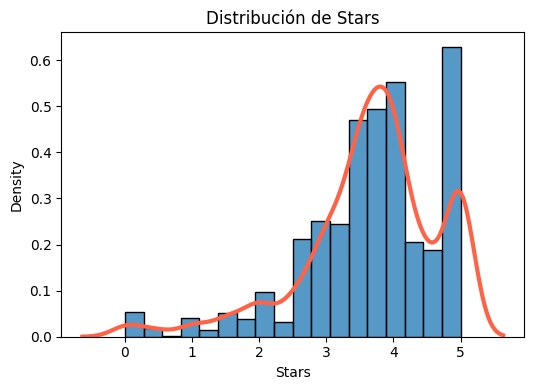

In [ ]:
plot_hist(df, ['Stars'], _bins=18)

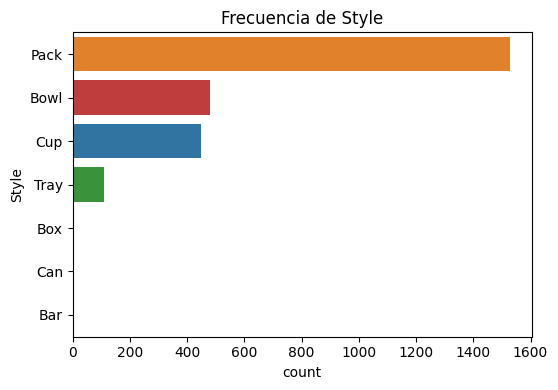

In [ ]:
plot_count(df, ['Style'])

> Conclusión
> - Debido a que la columna Stars que nos sirve para poder clasificar si un ramen e bueno o malo es una variable continua se puede generar una división con la mediana para obtener la clasificación entre buenos y malos.

In [ ]:
# Generar una variable categórica para clasificar los ramen
df['Star_cat'] = df['Stars'].apply(lambda x: 'Bueno' if x >= df['Stars'].median() else 'Malo')
df = df.drop(['Stars'], axis=1)
df.head()

,Brand,Variety,Style,Country,Star_cat
0,New Touch,T's Restaurant Tantanmen,Cup,Japan,Bueno
1,Just Way,Noodles Spicy Hot Sesame Spicy Hot Sesame Guan...,Pack,Taiwan,Malo
2,Nissin,Cup Noodles Chicken Vegetable,Cup,USA,Malo
3,Wei Lih,GGE Ramen Snack Tomato Flavor,Pack,Taiwan,Malo
4,Ching's Secret,Singapore Curry,Pack,India,Bueno


In [ ]:
df['Star_cat'].value_counts()/len(df)

,count
Star_cat,
Bueno,0.57
Malo,0.43


## 2. Preprocesar los datos

Realizar el preprocesamiento de los datos, incluyendo la normalización o estandarización de las características, codificación de variables categóricas y división del conjunto de datos en conjuntos de entrenamiento y prueba.

> Ahora se realiza el cambio de variables cualitativas a númericas para que puedan ser procesadas en los modelos de clasificación

In [33]:
df_cat = pd.get_dummies(df.loc[:, ['Brand', 'Style', 'Country']]).astype('int') # Se elimina Variety debido a que aumenta de forma explosiva la dimensionalidad
df_transform = pd.concat([df_cat, df['Star_cat']], axis=1)

df_transform.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2575 entries, 0 to 2579
Columns: 401 entries, Brand_1 To 3 Noodles to Star_cat
dtypes: int64(400), object(1)
memory usage: 7.9+ MB


In [35]:
df_transform.head()

,Brand_1 To 3 Noodles,Brand_7 Select,Brand_7 Select/Nissin,Brand_A-One,Brand_A-Sha Dry Noodle,Brand_A1,Brand_ABC,Brand_Acecook,Brand_Adabi,Brand_Ah Lai,...,Country_Singapore,Country_South Korea,Country_Sweden,Country_Taiwan,Country_Thailand,Country_UK,Country_USA,Country_United States,Country_Vietnam,Star_cat
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Bueno
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,Malo
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,Malo
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,Malo
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Bueno


In [141]:
# División de los conjuntos de prueba y test
X = df_transform.drop(['Star_cat'], axis=1)
y = df_transform['Star_cat']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [142]:
print("-"*80)
print("Cantidad de ramen por cada clase:")
print("-"*80)
print(y.value_counts())
print("-"*80)
print("Porcentaje por clase:")
print("-"*80)
print(y.value_counts() * 100 / len(y))

--------------------------------------------------------------------------------
Cantidad de ramen por cada clase:
--------------------------------------------------------------------------------
Star_cat
Bueno    1479
Malo     1096
Name: count, dtype: int64
--------------------------------------------------------------------------------
Porcentaje por clase:
--------------------------------------------------------------------------------
Star_cat
Bueno   57.44
Malo    42.56
Name: count, dtype: float64


## 3. Modelos de clasificación


Dividir los datos en conjuntos de entrenamiento y prueba y entrenar dos modelos de clasificación: uno utilizando Regresión Logística y otro utilizando Support Vector Machine (SVM). Estos modelos servirán para determinar si un paquete de ramen es "bueno" o "malo" en función de las características proporcionadas y realiza una búsqueda de hiperparámetros.

In [143]:
# Validación cruzada estratificada (5 folds)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
# Obtener las clases
class_names = y.unique().tolist()
class_names

['Bueno', 'Malo']

### 3.1 Regresión Logística

> Entrenamiento

In [144]:
lr = Pipeline([
    ("lr", LogisticRegression(max_iter=5000, solver="saga", penalty="l2"))
])

# Búsqueda de hiperparámetros (GridSearchCV)
param_grid = [
    # Solo L2, rápido
    {
        "lr__penalty": ["l2"],
        "lr__C": [0.001, 0.01, 0.1, 1.0],
        "lr__solver": ["lbfgs", "saga"],
        "lr__class_weight": ["balanced"]
    }
]

grid = GridSearchCV(
    estimator=lr,
    param_grid=param_grid,
    scoring="roc_auc",
    cv=cv,
    n_jobs=-1
)

grid.fit(X_train, y_train)

# Evaluación de los mejores parámetros
best_params = grid.best_params_
best_score = grid.best_score_
print("Mejores hiperparámetros:", best_params)
print("Puntaje del modelo con los mejores hiperparámetros:", best_score)

# Mejor modelo
best_lr = grid.best_estimator_

Mejores hiperparámetros: {'lr__C': 1.0, 'lr__class_weight': 'balanced', 'lr__penalty': 'l2', 'lr__solver': 'lbfgs'}
Puntaje del modelo con los mejores hiperparámetros: 0.7305644655068487


> Evaluación

In [145]:
y_pred_train = best_lr.predict(X_train)

print(f"\nAccuracy en train: {accuracy_score(y_train, y_pred_train):.3f}")
print("\nReporte de clasificación en train:")
print(classification_report(y_train, y_pred_train, digits=3))


Accuracy en train: 0.738

Reporte de clasificación en train:
              precision    recall  f1-score   support

       Bueno      0.798     0.731     0.763      1188
        Malo      0.671     0.748     0.708       872

    accuracy                          0.738      2060
   macro avg      0.735     0.740     0.735      2060
weighted avg      0.744     0.738     0.740      2060



### 3.2 SVM

> Entrenamiento

In [148]:
svc = Pipeline([
    ("svm", SVC(max_iter=5000))
])

# Búsqueda de hiperparámetros (GridSearchCV)
param_grid = {
    "svm__kernel": ["linear"],
    "svm__C": [0.001, 0.01, 0.5, 1.0, 5.0],
    "svm__class_weight": ["balanced"]
}

grid = GridSearchCV(
    estimator=svc,
    param_grid=param_grid,
    scoring="roc_auc",
    cv=cv,
    n_jobs=-1
)

grid.fit(X_train, y_train)

# Evaluación de los mejores parámetros
best_params = grid.best_params_
best_score = grid.best_score_
print("Mejores hiperparámetros:", best_params)
print("Puntaje del modelo con los mejores hiperparámetros:", best_score)

# Mejor modelo
best_svm = grid.best_estimator_

Mejores hiperparámetros: {'svm__C': 0.5, 'svm__class_weight': 'balanced', 'svm__kernel': 'linear'}
Puntaje del modelo con los mejores hiperparámetros: 0.7096082747372192


> Evaluación

In [149]:
y_pred_train = best_svm.predict(X_train)

print(f"\nAccuracy en train: {accuracy_score(y_train, y_pred_train):.3f}")
print("\nReporte de clasificación en train:")
print(classification_report(y_train, y_pred_train, digits=3))


Accuracy en train: 0.730

Reporte de clasificación en train:
              precision    recall  f1-score   support

       Bueno      0.789     0.726     0.756      1188
        Malo      0.664     0.735     0.697       872

    accuracy                          0.730      2060
   macro avg      0.726     0.731     0.727      2060
weighted avg      0.736     0.730     0.731      2060



## 4. Evaluar modelos

Evaluar el rendimiento de ambos modelos utilizando métricas relevantes para problemas de clasificación, como precisión, recall, F1-score y el área bajo la curva ROC (AUC-ROC). A partir de esto, debes comparar y analizar los resultados obtenidos por cada modelo para determinar cuál es más adecuado para este problema específico.

### Regresión Logística (LR)

Regresión Logística Reporte de clasificación (train):
              precision    recall  f1-score   support

           0      0.798     0.731     0.763      1188
           1      0.671     0.748     0.708       872

    accuracy                          0.738      2060
   macro avg      0.735     0.740     0.735      2060
weighted avg      0.744     0.738     0.740      2060

Regresión Logística Reporte de clasificación (test):
              precision    recall  f1-score   support

           0      0.690     0.612     0.648       291
           1      0.560     0.643     0.599       224

    accuracy                          0.625       515
   macro avg      0.625     0.627     0.624       515
weighted avg      0.634     0.625     0.627       515



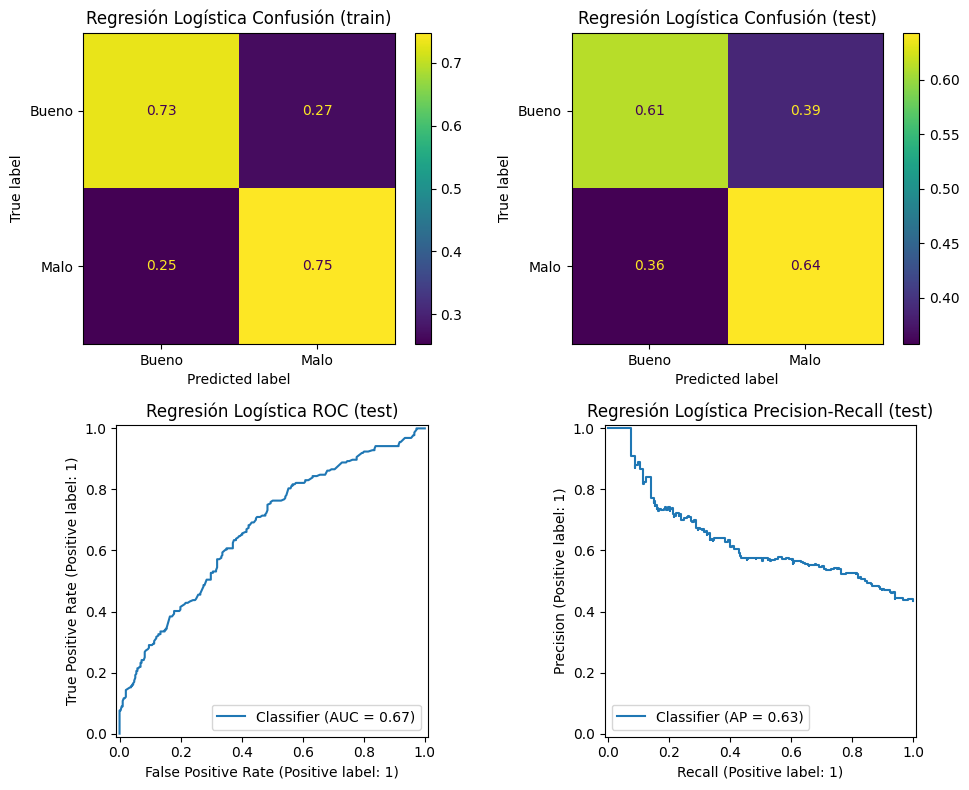

{'train_accuracy': 0.7383495145631068,
 'train_balanced_accuracy': np.float64(0.739593951749915),
 'train_precision_weighted': 0.7444292242008539,
 'train_recall_weighted': 0.7383495145631068,
 'train_f1_weighted': 0.739688969500468,
 'train_mcc': np.float64(0.47429522704297006),
 'test_accuracy': 0.625242718446602,
 'test_balanced_accuracy': np.float64(0.6272704958271969),
 'test_precision_weighted': 0.6335479019163578,
 'test_recall_weighted': 0.625242718446602,
 'test_f1_weighted': 0.6268350207232907,
 'test_mcc': np.float64(0.25237818963553804),
 'train_roc_auc': np.float64(0.8173371714082723),
 'test_roc_auc': np.float64(0.672948883161512),
 'train_pr_auc': np.float64(0.7780219689186431),
 'test_pr_auc': np.float64(0.6327729489560536)}

In [150]:
eval_model(best_lr, X_train, y_train, X_test, y_test, class_names, title_prefix="Regresión Logística", label_map={"Malo": 1, "Bueno": 0})

### SVM (SVM)

SVC Reporte de clasificación (train):
              precision    recall  f1-score   support

           0      0.774     0.776     0.775      1188
           1      0.694     0.692     0.693       872

    accuracy                          0.740      2060
   macro avg      0.734     0.734     0.734      2060
weighted avg      0.740     0.740     0.740      2060

SVC Reporte de clasificación (test):
              precision    recall  f1-score   support

           0      0.678     0.687     0.683       291
           1      0.586     0.576     0.581       224

    accuracy                          0.639       515
   macro avg      0.632     0.632     0.632       515
weighted avg      0.638     0.639     0.638       515



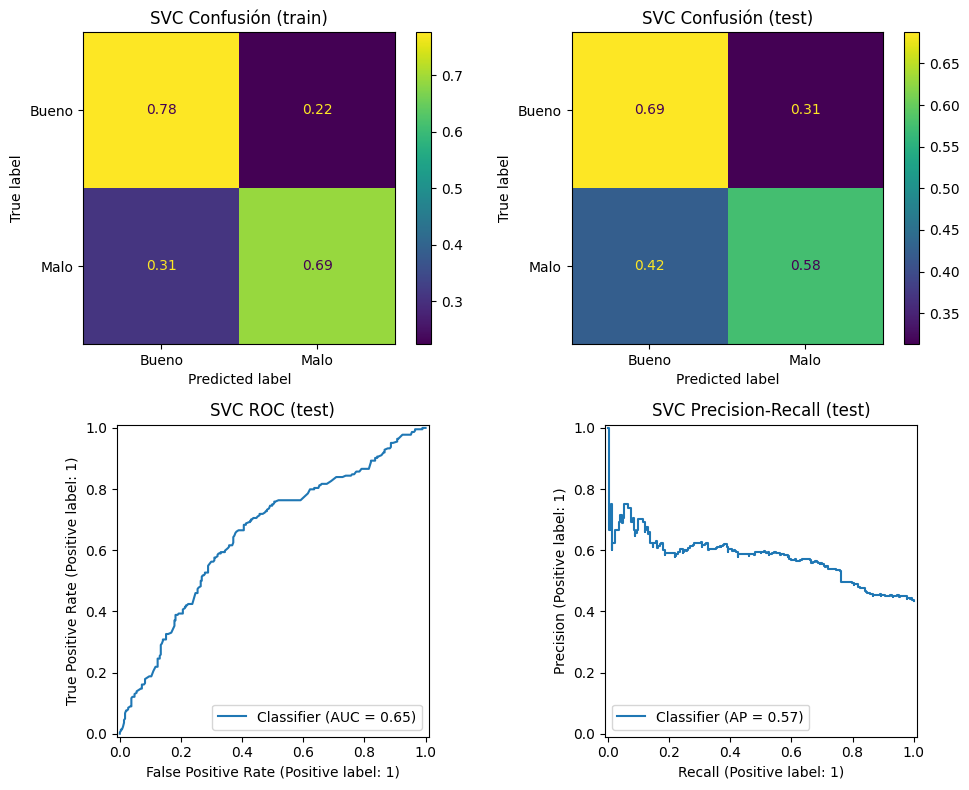

{'train_accuracy': 0.7402912621359223,
 'train_balanced_accuracy': np.float64(0.733804018781083),
 'train_precision_weighted': 0.7401744101800969,
 'train_recall_weighted': 0.7402912621359223,
 'train_f1_weighted': 0.7402312546701236,
 'train_mcc': np.float64(0.4678241760024628),
 'test_accuracy': 0.6388349514563106,
 'test_balanced_accuracy': np.float64(0.6315890402552773),
 'test_precision_weighted': 0.638123475997427,
 'test_recall_weighted': 0.6388349514563106,
 'test_f1_weighted': 0.6384407270851488,
 'test_mcc': np.float64(0.2637532807077617),
 'train_roc_auc': np.float64(0.7851638518209618),
 'test_roc_auc': np.float64(0.6515709376534119),
 'train_pr_auc': np.float64(0.7106033989402483),
 'test_pr_auc': np.float64(0.5749253372015826)}

In [151]:
eval_model(best_svm, X_train, y_train, X_test, y_test, class_names, title_prefix="SVC", label_map={"Malo": 1, "Bueno": 0})

### Conclusiones finales

* **Rendimiento global (test)**: En datos de prueba, ambos modelos entregan un rendimiento similar, con una ligera ventaja del SVC

  * Regresión logística
    * Accuracy: 0.625
    * Balanced accuracy: 0.627
    * MCC: 0.252
    * ROC AUC: 0.673
    * PR AUC: 0.633
  * SVC (kernel lineal)
    * Accuracy: 0.639
    * Balanced accuracy: 0.632
    * MCC: 0.264
    * ROC AUC: 0.652
    * PR AUC: 0.575

  En resumen: SVC clasifica un poco mejor (accuracy/MCC), pero la regresión logística modela mejor las probabilidades y el ranking de riesgo (ROC AUC y PR AUC).

* **Desbalance por clase**:

  * **Balanced accuracy**: Las métricas de balanced accuracy (~0.63 en ambos modelos) son muy similares al accuracy global.

* **Probabilidades / ranking**:

  * La regresión logística genera probabilidades más útiles y mejor ranking (especialmente para la clase “Malo” al comparar las matrices de confusión del conjunto test).

* **Sobreajuste (gap train–test)**:

  | Métrica      | Regresión Logística (Train - Test) | Gap RL  | SVC (Train - Test) | Gap SVC |
  |--------------|------------------------------------|---------|---------------------|---------|
  | Accuracy     | 0.738 - 0.625                      | ~0.11   | 0.740 - 0.639       | ~0.10   |
  | ROC AUC      | 0.817 - 0.673                      | ~0.14   | 0.785 - 0.652       | ~0.13   |
  | PR AUC       | 0.778 - 0.633                      | ~0.15   | 0.711 - 0.575       | ~0.14   |

  * Ambos modelos muestran sobreajuste moderado (gap bajos y similares)
  * Rinden claramente mejor en train que en test

**Conclusión**

* Si se quiere maximizar accuracy/MCC: el SVC lineal es marginalmente mejor.
* Si se quiere una mejor relación entre detección de clases scoring/riesgo la regresión logística es claramente preferible, porque ofrece mejor ROC AUC y mejor PR AUC en test (que también separa las clases y calidad en clases desbalanceadas).

---


## Recomendación

> Debido a que el objetivo es solo clasificar si un ramen es Bueno o Malo lo que es preferible usar un módelo con MCC (calidad global) y accuracy mayor, en eset caso SVC es ligeramente mejor.
